# FUNSD

In [8]:
import pandas as pd 
import numpy as np
import seaborn as sns

In [11]:
import json
import os
import matplotlib.pyplot as plt

In [16]:
sample_funsd_data = pd.read_json('data/funsd/training_data/annotations/00040534.json')
sample_funsd_data

,form
0,"{'box': [84, 109, 136, 119], 'text': 'COMPOUND..."
1,"{'box': [85, 141, 119, 152], 'text': 'SOURCE',..."
2,"{'box': [84, 203, 155, 214], 'text': 'INVESTIG..."
3,"{'box': [84, 232, 141, 243], 'text': 'SIGNATUR..."
4,"{'box': [508, 170, 551, 183], 'text': 'REPORTE..."
...,...
76,"{'text': 'LORILLARO RESEARCH CENTER', 'box': [..."
77,"{'text': 'FORM 7 5/80', 'box': [676, 946, 732,..."
78,"{'text': 'of respiratory depression, constrict..."
79,{'text': 'This compound appears to act as a CN...


В LayoutLMv3 используется специальный формат

In [19]:
def convert_funsd_to_layoutlmv3(funsd_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for file in os.listdir(os.path.join(funsd_dir, "annotations")):
        with open(os.path.join(funsd_dir, "annotations", file)) as f:
            data = json.load(f)
        converted_data = []
        for item in data["form"]:
            converted_data.append({
                "text": item["text"],
                "bbox": item["box"],  # [x, y, w, h]
                "label": item["label"]
            })
        output_file = os.path.join(output_dir, file)
        with open(output_file, "w") as f:
            json.dump(converted_data, f, ensure_ascii=False)

convert_funsd_to_layoutlmv3("data/funsd/training_data", "data/converted_funsd")

In [20]:
sample_funsd_data 

,form
0,"{'box': [84, 109, 136, 119], 'text': 'COMPOUND..."
1,"{'box': [85, 141, 119, 152], 'text': 'SOURCE',..."
2,"{'box': [84, 203, 155, 214], 'text': 'INVESTIG..."
3,"{'box': [84, 232, 141, 243], 'text': 'SIGNATUR..."
4,"{'box': [508, 170, 551, 183], 'text': 'REPORTE..."
...,...
76,"{'text': 'LORILLARO RESEARCH CENTER', 'box': [..."
77,"{'text': 'FORM 7 5/80', 'box': [676, 946, 732,..."
78,"{'text': 'of respiratory depression, constrict..."
79,{'text': 'This compound appears to act as a CN...


# sroie

In [5]:
import os
import json
import pandas as pd
from collections import defaultdict
from PIL import Image
import pytesseract
import cv2
import numpy as np

# Папки с данными SROIE
IMAGE_DIR = "data/sroie/train1"
ANNOTATION_DIR = "data/sroie/train1"
OCR_DIR = "data/sroie/train2"
OUTPUT_DIR = "converted_sroie"

# Создание выходной папки
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Метки для ключевых полей
KEY_FIELDS = ["company", "date", "address", "total"]
IOB2_LABELS = {key: f"B-{key.upper()}" for key in KEY_FIELDS}
IOB2_LABELS.update({key: f"I-{key.upper()}" for key in KEY_FIELDS})
IOB2_LABELS["O"] = "O"

# Логирование проблемных файлов
PROBLEM_LOG = "problem_files.log"
problem_files = []

def log_problem(file_name, reason):
    """Логирование проблемных файлов."""
    with open(PROBLEM_LOG, "a", encoding="utf-8") as f:
        f.write(f"Файл: {file_name}, Причина: {reason}\n")
    problem_files.append((file_name, reason))

def read_key_value_annotation(file_path):
    """Чтение аннотаций ключ-значение из .txt файла."""
    key_value = {}
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            lines = f.readlines()
            content = "".join(lines).strip()
            if content.startswith("{"):
                data = json.loads(content)
                key_value = {k: v for k, v in data.items() if k in KEY_FIELDS}
            else:
                for line in lines:
                    if ":" in line:
                        key, value = line.strip().split(":", 1)
                        key_value[key.strip()] = value.strip()
    except Exception as e:
        log_problem(file_path, f"Ошибка чтения аннотации: {e}")
    return key_value

def read_ocr_data(file_path):
    """Чтение OCR-данных (координаты и текст)."""
    ocr_data = []
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            content = f.read().strip()
            # Проверка на JSON-формат
            if content.startswith("{"):
                try:
                    data = json.load(open(file_path, encoding="utf-8"))
                    for item in data.get("words", []):
                        bbox = item.get("bbox")
                        text = item.get("text")
                        if bbox and text and len(bbox) == 4:
                            ocr_data.append({"text": text, "bbox": bbox})
                        else:
                            log_problem(file_path, f"Некорректный JSON: {item}")
                except json.JSONDecodeError as e:
                    log_problem(file_path, f"Ошибка декодирования JSON: {e}")
            else:
                # Обработка текстового формата
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    parts = line.split(",")
                    if len(parts) >= 9:
                        try:
                            coords = [int(x) for x in parts[:8]]
                            text = ",".join(parts[8:]).strip()
                            x_min = min(coords[0], coords[2], coords[4], coords[6])
                            y_min = min(coords[1], coords[3], coords[5], coords[7])
                            x_max = max(coords[0], coords[2], coords[4], coords[6])
                            y_max = max(coords[1], coords[3], coords[5], coords[7])
                            bbox = [x_min, y_min, x_max - x_min, y_max - y_min]
                            ocr_data.append({"text": text, "bbox": bbox})
                        except ValueError:
                            log_problem(file_path, f"Пропущена строка: {line}")
                            continue
                    else:
                        log_problem(file_path, f"Недостаточно элементов в строке: {line}")
    except Exception as e:
        log_problem(file_path, f"Ошибка чтения OCR: {e}")
    return ocr_data

def apply_tesseract(image_path):
    """Применение Tesseract для извлечения OCR-данных."""
    try:
        image = Image.open(image_path)
        ocr_result = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT, lang="eng")
        ocr_data = []
        for i in range(len(ocr_result["text"])):
            if ocr_result["text"][i].strip():
                ocr_data.append({
                    "text": ocr_result["text"][i],
                    "bbox": [
                        ocr_result["left"][i],
                        ocr_result["top"][i],
                        ocr_result["width"][i],
                        ocr_result["height"][i]
                    ]
                })
        return ocr_data
    except Exception as e:
        log_problem(image_path, f"Ошибка Tesseract: {e}")
        return []

def assign_iob2_labels(ocr_data, key_value):
    """Присвоение меток IOB2 словам на основе ключ-значений."""
    labeled_data = []
    for item in ocr_data:
        text = item["text"]
        label = "O"
        for key, value in key_value.items():
            if value and text.lower() in value.lower():
                if not labeled_data or labeled_data[-1]["label"] != f"I-{key.upper()}":
                    label = f"B-{key.upper()}"
                else:
                    label = f"I-{key.upper()}"
                break
        labeled_data.append({
            "text": text,
            "bbox": item["bbox"],
            "label": label
        })
    return labeled_data

def convert_sroie_to_layoutlmv3():
    """Основная функция преобразования SROIE."""
    for file_name in os.listdir(IMAGE_DIR):
        if file_name.endswith(".jpg"):
            base_name = file_name.replace(".jpg", "")
            image_path = os.path.join(IMAGE_DIR, file_name)
            annotation_path = os.path.join(ANNOTATION_DIR, f"{base_name}.txt")
            ocr_path = os.path.join(OCR_DIR, f"{base_name}.txt")

            if not (os.path.exists(annotation_path) and os.path.exists(ocr_path)):
                log_problem(base_name, "Отсутствуют аннотации или OCR")
                continue

            # Чтение данных
            key_value = read_key_value_annotation(annotation_path)
            ocr_data = read_ocr_data(ocr_path)

            # Если OCR-данные пустые, попробуем Tesseract
            if not ocr_data and os.path.exists(image_path):
                print(f"Применение Tesseract для {base_name}")
                ocr_data = apply_tesseract(image_path)

            if not ocr_data:
                log_problem(base_name, "Нет корректных OCR-данных")
                continue

            # Присвоение меток
            labeled_data = assign_iob2_labels(ocr_data, key_value)

            # Сохранение результата
            output_json = os.path.join(OUTPUT_DIR, f"{base_name}.json")
            with open(output_json, "w", encoding="utf-8") as f:
                json.dump(labeled_data, f, ensure_ascii=False, indent=2)

            print(f"Обработан файл {base_name}")

# Запуск преобразования
if os.path.exists(PROBLEM_LOG):
    os.remove(PROBLEM_LOG)
convert_sroie_to_layoutlmv3()

# Вывод статистики
print(f"\nОбработано файлов: {len(os.listdir(OUTPUT_DIR))}")
print(f"Пропущено файлов: {len(problem_files)}")
print(f"Лог проблем сохранен в {PROBLEM_LOG}")

Применение Tesseract для X51005442376
Применение Tesseract для X51009453804
Применение Tesseract для X51006401723
Применение Tesseract для X51006913023
Применение Tesseract для X51007846451
Применение Tesseract для X51006311780
Применение Tesseract для X51005719862
Применение Tesseract для X51007339133
Применение Tesseract для X51005605285(2)
Применение Tesseract для X51006008057
Применение Tesseract для X51005719902
Применение Tesseract для X51006557161
Применение Tesseract для X51006857265
Применение Tesseract для X51005757304
Применение Tesseract для X51005447839
Применение Tesseract для X51006332575
Применение Tesseract для X00016469612
Применение Tesseract для X51006389888
Применение Tesseract для X51006328920
Применение Tesseract для X51006620190
Применение Tesseract для X51006620191
Применение Tesseract для X51008042791
Применение Tesseract для X51006329395
Применение Tesseract для X51008142034
Применение Tesseract для X51008114266
Применение Tesseract для X51007339117(1)
Примен

In [3]:
import cv2
import json

def visualize_bboxes(image_path, annotation_path):
    image = cv2.imread(image_path)
    with open(annotation_path) as f:
        annotations = json.load(f)
    for item in annotations:
        x, y, w, h = item["bbox"]
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(image, item["label"], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    cv2.imwrite("imgs/output.jpg", image)

visualize_bboxes("data/funsd/training_data/images/00040534.png", "data/converted_funsd/00040534.json")

Теперь данные предобработаны и могут быть использованы в модели LayoutLMv3.


# Синтетическая генерация данных
в открытых датасетах нет данных для российских паспортов. Необходимо сгенерировать синтетические данные для этого.

In [37]:
from docx import Document
import random

def generate_contract(template_path, output_path):
    doc = Document()
    doc.add_paragraph(f"Договор № {random.randint(1000, 9999)} от «{random.randint(1, 31)}» {random.choice(['января', 'февраля'])} 202{random.randint(3, 5)} г.")
    doc.add_paragraph(f"Город: {random.choice(['Москва', 'Санкт-Петербург'])}")
    doc.add_paragraph(f"Сторона 1: {random.choice(['Иванов И.И.', 'Петров П.П.'])}")
    doc.save(output_path)

generate_contract("template.docx", "contract_1.docx")

Создание шаблона изображений для паспортов при помози PIL

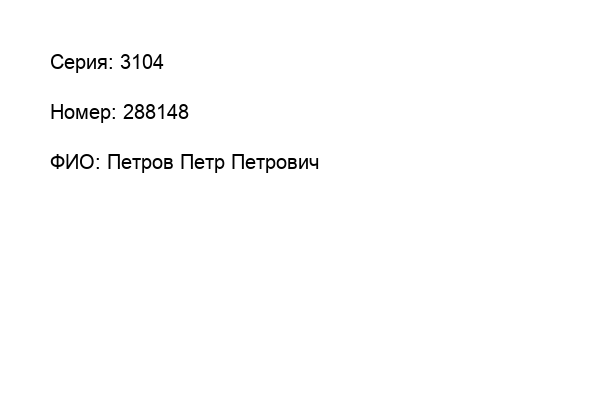

In [16]:
from PIL import Image, ImageDraw, ImageFont
import random

def generate_passport_image(output_path):
    image = Image.new("RGB", (600, 400), "white")
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype("Arial", 20)
    draw.text((50, 50), f"Серия: {random.randint(1000, 9999)}", fill="black", font=font)
    draw.text((50, 100), f"Номер: {random.randint(100000, 999999)}", fill="black", font=font)
    draw.text((50, 150), f"ФИО: {random.choice(['Иванов Иван Иванович', 'Петров Петр Петрович'])}", fill="black", font=font)
    image.save(output_path)
    return image

generate_passport_image("data/generated_passports/images/passport_1.jpg")

Теперь конвертируем документы в изображение

In [21]:
from docx2pdf import convert
convert("contract_1.docx", "contract_1.pdf")

  0%|          | 0/1 [00:00<?, ?it/s]

In [32]:
from pdf2image import convert_from_path
images = convert_from_path("contract_1.pdf", dpi=200)
images[0].save("contract_1.jpg", "JPEG")

# Генерация аннотаций
нужно сгенерировать аннотации в формате json для каждого изображения, чтобы потом загнать в модель

In [7]:
def generate_passport_annotation(image_path, output_json):
    annotations = [
        {"text": "Серия: 1234", "bbox": [50, 50, 100, 20], "label": "SERIES"},
        {"text": "Номер: 567890", "bbox": [50, 100, 120, 20], "label": "NUMBER"},
        {"text": "ФИО: Иванов Иван Иванович", "bbox": [50, 150, 200, 20], "label": "NAME"}
    ]
    with open(output_json, "w") as f:
        json.dump(annotations, f, ensure_ascii=False)

generate_passport_annotation("data/generated_passports/images/passport_1.jpg", "data/generated_passports/annotations/passport_1.json")


In [9]:
for i in range(100):
    generate_passport_image(f"data/generated_passports/images/passport_{i}.jpg")
    passport_path = f"data/generated_passports/images/passport_{i}.jpg"
    json_path = f"data/generated_passports/annotations/passport_{i}.json"
    generate_passport_annotation(passport_path, json_path)

In [34]:
for i in range(100):
    contract_path = f"contract_{i}.docx"
    image_path = f"contract_{i}.jpg"
    json_path = f"contract_{i}.json"
    generate_contract("template.docx", contract_path)
    convert(contract_path, f"contract_{i}.pdf")
    images = convert_from_path(f"contract_{i}.pdf")
    images[0].save(image_path)
    generate_passport_annotation(image_path, json_path)  # Адаптируйте под договор

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

PDFPageCountError: Unable to get page count.
I/O Error: Couldn't open file 'contract_4.pdf': No such file or directory.


In [ ]:
import os
import docx
from docx2pdf import convert
from pdf2image import convert_from_path
import json
import logging

# Папка для хранения сгенерированных файлов
OUTPUT_DIR = "/Users/max/school_informatics/camp25_cu/scientificProject/data/generated_contracts"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Путь к шаблону
TEMPLATE_PATH = "/Users/max/school_informatics/camp25_cu/scientificProject/data/template.docx"

# Настройка логирования
logging.basicConfig(filename=os.path.join(OUTPUT_DIR, "contract_generation.log"), 
                    level=logging.INFO, 
                    format="%(asctime)s - %(levelname)s - %(message)s")

# Создание template.docx, если он не существует
def create_template_docx(template_path):
    if os.path.exists(template_path):
        logging.info(f"Шаблон уже существует: {template_path}")
        return
    
    try:
        doc = docx.Document()
        doc.add_heading("Договор", level=1)
        doc.add_paragraph("Номер договора: [НОМЕР]")
        doc.add_paragraph("Дата: [ДАТА]")
        doc.add_paragraph("Сторона 1: [КОМПАНИЯ А]")
        doc.add_paragraph("Сторона 2: [КОМПАНИЯ Б]")
        doc.add_paragraph("Условия договора: [УСЛОВИЯ]")
        doc.save(template_path)
        logging.info(f"Создан шаблон: {template_path}")
    except Exception as e:
        logging.error(f"Ошибка создания шаблона {template_path}: {e}")
        raise

# Проверка существования шаблона и его создание
create_template_docx(TEMPLATE_PATH)
if not os.path.exists(TEMPLATE_PATH):
    error_msg = f"Не удалось создать шаблон: {TEMPLATE_PATH}. Проверьте права доступа."
    logging.error(error_msg)
    raise FileNotFoundError(error_msg)

# Проверка прав доступа к папке
try:
    test_file = os.path.join(OUTPUT_DIR, "test.txt")
    with open(test_file, "w") as f:
        f.write("test")
    os.remove(test_file)
except PermissionError:
    error_msg = f"Нет прав доступа к папке {OUTPUT_DIR}. Выполните: chmod -R 777 {OUTPUT_DIR}"
    logging.error(error_msg)
    raise PermissionError(error_msg)

# Функция генерации договора
def generate_contract(template_path, output_path):
    try:
        doc = docx.Document(template_path)
        # Замена плейсхолдеров (пример)
        for paragraph in doc.paragraphs:
            if "[НОМЕР]" in paragraph.text:
                paragraph.text = paragraph.text.replace("[НОМЕР]", f"№{os.path.basename(output_path)}")
            if "[ДАТА]" in paragraph.text:
                paragraph.text = paragraph.text.replace("[ДАТА]", "2025-04-23")
            if "[КОМПАНИЯ А]" in paragraph.text:
                paragraph.text = paragraph.text.replace("[КОМПАНИЯ А]", f"Компания А{i}")
            if "[КОМПАНИЯ Б]" in paragraph.text:
                paragraph.text = paragraph.text.replace("[КОМПАНИЯ Б]", f"Компания Б{i}")
            if "[УСЛОВИЯ]" in paragraph.text:
                paragraph.text = paragraph.text.replace("[УСЛОВИЯ]", "Стандартные условия договора")
        doc.save(output_path)
        logging.info(f"Создан договор: {output_path}")
    except Exception as e:
        logging.error(f"Ошибка генерации договора {output_path}: {e}")
        raise

# Функция генерации аннотаций
def generate_passport_annotation(image_path, json_path):
    try:
        # Пример аннотации для договора
        annotations = [
            {"text": f"Contract {os.path.basename(image_path)}", "bbox": [50, 50, 200, 30], "label": "contract_num"},
            {"text": "2025-04-23", "bbox": [50, 100, 150, 30], "label": "date"},
            {"text": f"Компания А{i}", "bbox": [50, 150, 200, 30], "label": "party_a"},
            {"text": f"Компания Б{i}", "bbox": [50, 200, 200, 30], "label": "party_b"}
        ]
        with open(json_path, "w", encoding="utf-8") as f:
            json.dump(annotations, f, ensure_ascii=False, indent=2)
        logging.info(f"Создана аннотация: {json_path}")
    except Exception as e:
        logging.error(f"Ошибка генерации аннотации {json_path}: {e}")
        raise

# Основной цикл
for i in range(100):
    try:
        contract_path = os.path.join(OUTPUT_DIR, f"contract_{i}.docx")
        pdf_path = os.path.join(OUTPUT_DIR, f"contract_{i}.pdf")
        image_path = os.path.join(OUTPUT_DIR, f"contract_{i}.jpg")
        json_path = os.path.join(OUTPUT_DIR, f"contract_{i}.json")

        # Генерация договора
        generate_contract(TEMPLATE_PATH, contract_path)

        # Конвертация в PDF
        convert(contract_path, pdf_path)
        logging.info(f"Конвертирован в PDF: {pdf_path}")

        # Конвертация PDF в изображение
        images = convert_from_path(pdf_path)
        images[0].save(image_path, "JPEG")
        logging.info(f"Сохранено изображение: {image_path}")

        # Генерация аннотаций
        generate_passport_annotation(image_path, json_path)

        print(f"Обработан контракт {i}")

    except PermissionError as e:
        logging.error(f"Ошибка доступа для контракта {i}: {e}")
        print(f"Ошибка доступа для контракта {i}. Проверьте права папки {OUTPUT_DIR}.")
    except Exception as e:
        logging.error(f"Ошибка обработки контракта {i}: {e}")
        print(f"Ошибка обработки контракта {i}: {e}")

print(f"Генерация завершена. Файлы сохранены в {OUTPUT_DIR}")
print(f"Лог ошибок: {os.path.join(OUTPUT_DIR, 'contract_generation.log')}")

теперь добавим шума картинкам, дабы они были больше схожи с реальными паспортами

In [17]:
import cv2
import numpy as np

def add_noise(image_path, output_path):
    image = cv2.imread(image_path)
    noise = np.random.normal(0, 25, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    cv2.imwrite(output_path, noisy_image)

for i in range(100):
    add_noise(f"data/generated_passports/images/passport_{i}.jpg", f"data/generated_passports/noisy/passport_{i}_noisy.jpg")


# Создание CSV файлов

In [20]:
import pandas as pd

data = []
for dataset in ["funsd/training_data", "sroie", "generated_passports", "generated_contracts"]:
    image_dir = f"data/{dataset}/images"
    annotation_dir = f"dataset/{dataset}/annotations"
    for img in os.listdir(image_dir):
        data.append({
            "image_path": f"{image_dir}/{img}",
            "annotation_path": f"{annotation_dir}/{img.replace('.jpg', '.json')}",
            "dataset": dataset
        })

df = pd.DataFrame(data)
df.to_csv("dataset.csv", index=False)

In [21]:
df

,image_path,annotation_path,dataset
0,data/funsd/training_data/images/92091873.png,dataset/funsd/training_data/annotations/920918...,funsd/training_data
1,data/funsd/training_data/images/91939637.png,dataset/funsd/training_data/annotations/919396...,funsd/training_data
2,data/funsd/training_data/images/87533049.png,dataset/funsd/training_data/annotations/875330...,funsd/training_data
3,data/funsd/training_data/images/01073843.png,dataset/funsd/training_data/annotations/010738...,funsd/training_data
4,data/funsd/training_data/images/92586242.png,dataset/funsd/training_data/annotations/925862...,funsd/training_data
...,...,...,...
1236,data/generated_contracts/images/contract_44.pdf,dataset/generated_contracts/annotations/contra...,generated_contracts
1237,data/generated_contracts/images/contract_50.pdf,dataset/generated_contracts/annotations/contra...,generated_contracts
1238,data/generated_contracts/images/contract_78.pdf,dataset/generated_contracts/annotations/contra...,generated_contracts
1239,data/generated_contracts/images/contract_87.pdf,dataset/generated_contracts/annotations/contra...,generated_contracts


In [22]:
from PIL import Image
for row in df.itertuples():
    try:
        Image.open(row.image_path)
    except Exception as e:
        print(f"Ошибка в файле {row.image_path}: {e}")

Ошибка в файле data/generated_contracts/images/contract_75.pdf: cannot identify image file 'data/generated_contracts/images/contract_75.pdf'
Ошибка в файле data/generated_contracts/images/contract_61.pdf: cannot identify image file 'data/generated_contracts/images/contract_61.pdf'
Ошибка в файле data/generated_contracts/images/contract_49.pdf: cannot identify image file 'data/generated_contracts/images/contract_49.pdf'
Ошибка в файле data/generated_contracts/images/contract_48.pdf: cannot identify image file 'data/generated_contracts/images/contract_48.pdf'
Ошибка в файле data/generated_contracts/images/contract_60.pdf: cannot identify image file 'data/generated_contracts/images/contract_60.pdf'
Ошибка в файле data/generated_contracts/images/contract_74.pdf: cannot identify image file 'data/generated_contracts/images/contract_74.pdf'
Ошибка в файле data/generated_contracts/images/contract_89.pdf: cannot identify image file 'data/generated_contracts/images/contract_89.pdf'
Ошибка в файл